In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

import numpy as np

env: CUDA_DEVICE_ORDER=PCI_BUS_ID


In [2]:
import numpy as np

import pythiamill as pm

In [3]:
fixed_options = [
    ### telling pythia to be quiet.
    'Print:quiet = on',
    'Init:showProcesses = off',
    'Init:showMultipartonInteractions = off',
    'Init:showChangedSettings = off',
    'Init:showChangedParticleData = off',
    'Next:numberCount=0',
    'Next:numberShowInfo=0',
    'Next:numberShowEvent=0',
    'Stat:showProcessLevel=off',
    'Stat:showErrors=off',
    
    ### seeting default parameters to Monash values
    "Tune:ee = 7",
    "Beams:idA = 11",
    "Beams:idB = -11",
    "Beams:eCM = 91.2",
    "WeakSingleBoson:ffbar2gmZ = on",
    "23:onMode = off",
    "23:onIfMatch = 1 -1",
    "23:onIfMatch = 2 -2",
    "23:onIfMatch = 3 -3",
    "23:onIfMatch = 4 -4",
    "23:onIfMatch = 5 -5",
]

In [4]:
def get_data(n_samples=2**14, alphaSvalue=0.1365, n_workers=4, seed=123, show_progress=False):
    options = fixed_options + [ 'TimeShower:alphaSvalue=%f' % alphaSvalue ]
    
    ### TuneMC detector provides the same features used in TuneMC paper
    detector = pm.utils.TuneMCDetector()
    
    mill = pm.PythiaMill(detector, options, batch_size=256, cache_size=4, n_workers=n_workers, seed=seed)
    
    ### sampling
    data = np.vstack([
        mill.sample()
        for _ in (
            lambda x: tqdm_notebook(x, postfix='data gen')
            if show_progress else
            lambda x: x
        )(range(n_samples // 256))
    ])
    
    mill.terminate()
    
    return data

In [5]:
X_true_train = get_data(show_progress=True)
X_true_val = get_data(show_progress=True)

In [6]:
#Discriminator

import tensorflow as tf
import keras

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten
from keras.activations import softplus, sigmoid, relu

from keras.utils.vis_utils import model_to_dot
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1)

tf_session = tf.InteractiveSession(config=tf.ConfigProto(
    gpu_options=gpu_options,

    ### uncomment to use cpu
    ###device_count = {'GPU': 0}
))

keras.backend.tensorflow_backend.set_session(tf_session)

Using TensorFlow backend.


In [11]:
activation = lambda x: relu(x, 0.05)

inputs = Input(shape=(445, ))

net = Dense(128, activation=activation)(inputs)
predictions = Dense(1, activation=sigmoid)(net)

discriminator = Model(inputs=inputs, outputs=predictions)
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

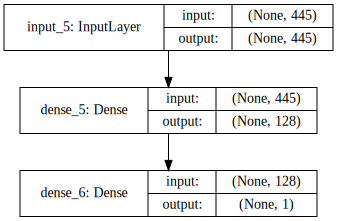

In [12]:
from IPython import display
from IPython.display import SVG

SVG(model_to_dot(discriminator, show_shapes=True).create(prog='dot', format='svg'))

In [13]:
initial_weights = discriminator.get_weights()

In [14]:
from sklearn.metrics import log_loss

def jensen_shannon(alphaSvalue, n_epoches=5):
    discriminator.set_weights(initial_weights)
    
    X_gen_train = get_data(alphaSvalue=alphaSvalue, show_progress=True)
    X_gen_val = get_data(alphaSvalue=alphaSvalue, show_progress=True)
    
    X_train = np.vstack([ X_gen_train, X_true_train ])
    y_train = np.hstack([ np.zeros(X_gen_train.shape[0]), np.ones(X_true_train.shape[0]) ]).astype('float32')
    
    history = discriminator.fit(x=X_train, y=y_train, batch_size=32, epochs=n_epoches, verbose=0)
    
    X_val = np.vstack([X_gen_val, X_true_val])
    y_val = np.hstack([ np.zeros(X_gen_val.shape[0]), np.ones(X_true_val.shape[0]) ]).astype('float32')
    
    proba = discriminator.predict(X_val)
    
    return np.log(2) - log_loss(y_val, proba, eps=1.0e-6)

In [15]:
%%time

jensen_shannon(0.25, n_epoches=20)


CPU times: user 1min 53s, sys: 35.5 s, total: 2min 28s
Wall time: 1min 20s


0.414490736246288

In [16]:
initial_weights = discriminator.get_weights()

In [17]:
from skopt import Optimizer

/mnt/mlhep2018/pyenv/versions/3.6.6/envs/mlhep/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [18]:
from skopt.acquisition import gaussian_ei as acq_func

def plot_bo(bo, suggestion=None, value=None):
    a, b = bo.space.bounds[0]
    
    ### getting the latest model
    model = bo.models[-1]
    
    xs = np.linspace(a, b, num=100)
    x_model = bo.space.transform(xs.reshape(-1, 1).tolist())
    
    mean, std = model.predict(x_model, return_std=True)
    
    plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.scatter(
        np.array(bo.Xi)[:, 0],
        np.array(bo.yi),
        color='red',
        label='observations'
    )
    if suggestion is not None:
        plt.scatter([suggestion], value, color='blue', label='suggestion')
    
    plt.plot(xs, mean, color='green', label='model')
    plt.fill_between(xs, mean - 1.96 * std, mean + 1.96 * std, alpha=0.1, color='green')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    acq = acq_func(x_model, model, np.min(bo.yi))
    plt.plot(xs, acq, label='Expected Improvement')
    plt.legend()
    
    plt.show()

In [19]:
bo = Optimizer(
    dimensions=[
        (0.06, 0.25)
    ],
    base_estimator='gp',
    n_initial_points=3,
    acq_func='EI',   
)

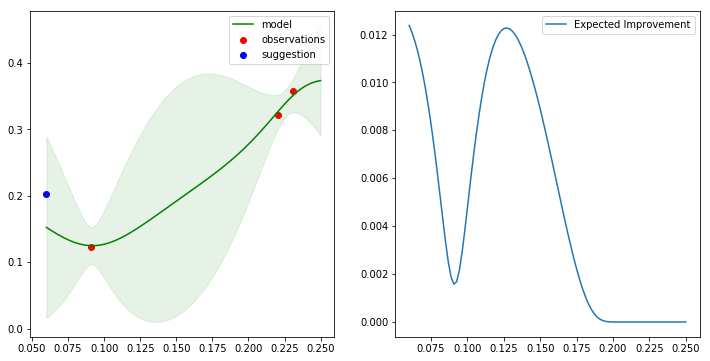

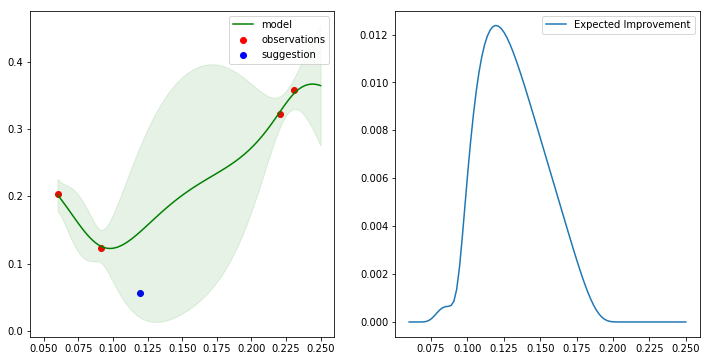

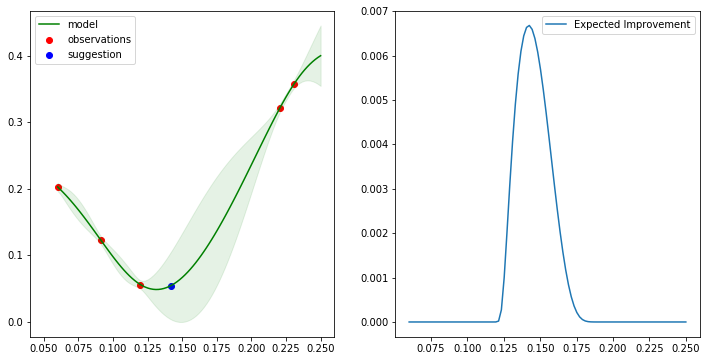

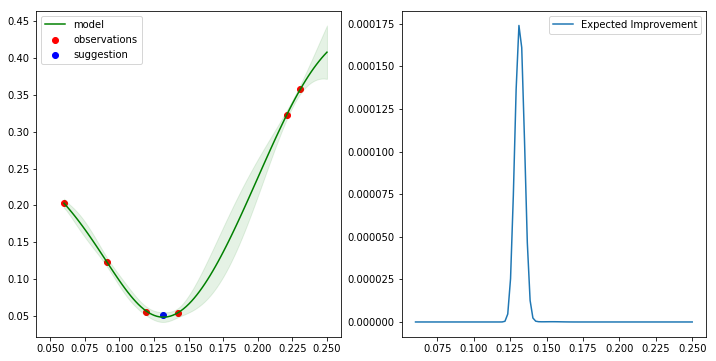

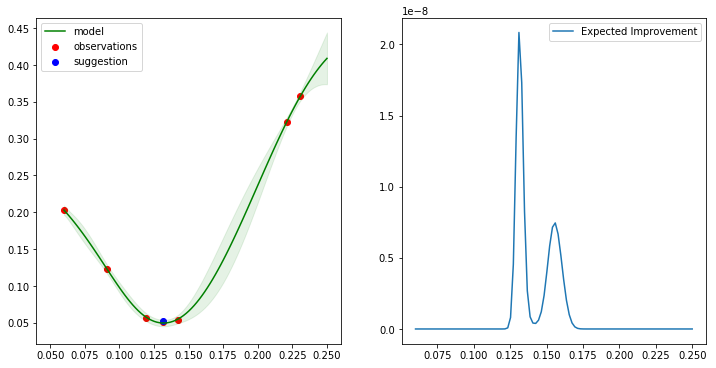

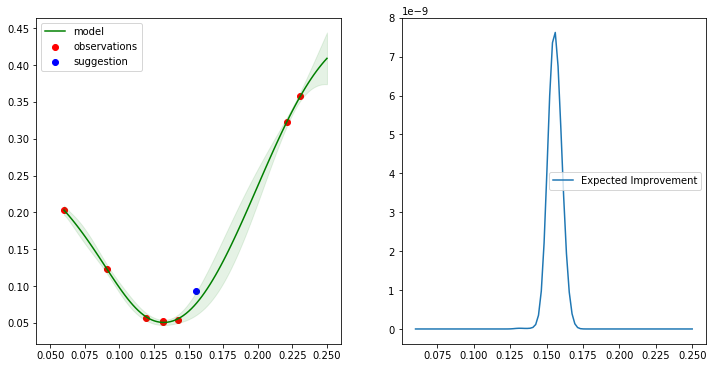

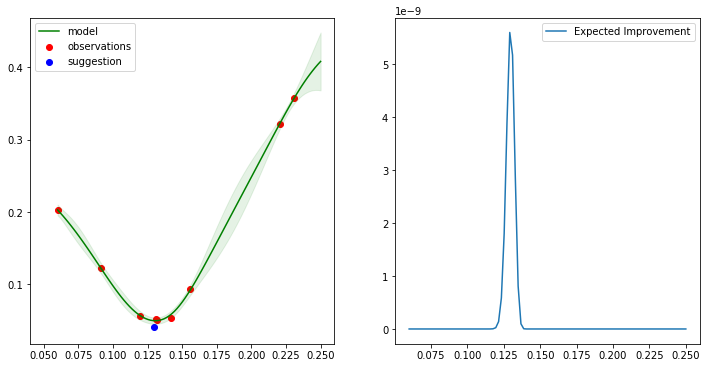

In [20]:
for i in range(10):
    x = bo.ask()
    f = jensen_shannon(x[0])

    if len(bo.models) > 0:
        plot_bo(bo, suggestion=x, value=f)
    
    bo.tell(x, f)

In [21]:
model = bo.models[-1]
space = bo.space
bo.Xi

[[0.22080332171532532],
 [0.23071208787895855],
 [0.09123942587207255],
 [0.06],
 [0.11961254873519747],
 [0.1421792236465652],
 [0.1315022639703643],
 [0.1313800363441191],
 [0.1554027878567259],
 [0.12972226906558793]]

In [22]:
xs = np.linspace(0.06, 0.25, num=100)
predicted_mean, predicted_std = model.predict(space.transform(xs.reshape(-1, 1)), return_std=True)

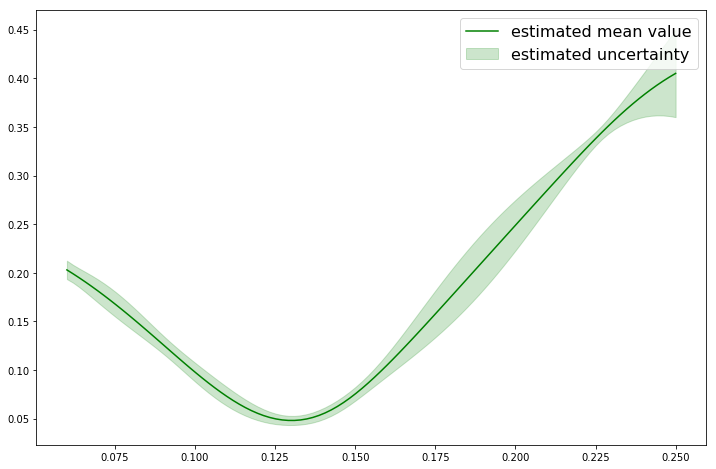

37
0.04815278854641386
0.13101010101010102


In [23]:
plt.figure(figsize=(12, 8))
plt.plot(xs, predicted_mean, color='green', label='estimated mean value')
plt.fill_between(
    xs, predicted_mean - 1.96 * predicted_std, predicted_mean + 1.96 * predicted_std,
    color='green', alpha=0.2,
    label='estimated uncertainty'
)
plt.legend(fontsize=16)
plt.show()
print(np.argmin(predicted_mean))
print(predicted_mean[np.argmin(predicted_mean)])
print(xs[np.argmin(predicted_mean)])

In [24]:
param_names20 = [
  "TimeShower:alphaSvalue",
  "TimeShower:pTmin",
  "TimeShower:pTminChgQ",

  "StringPT:sigma",
  "StringZ:bLund",
  "StringZ:aExtraSQuark",
  "StringZ:aExtraDiquark",
  "StringZ:rFactC",
  "StringZ:rFactB",

  "StringFlav:probStoUD",
  "StringFlav:probQQtoQ",
  "StringFlav:probSQtoQQ",
  "StringFlav:probQQ1toQQ0",
  "StringFlav:mesonUDvector",
  "StringFlav:mesonSvector",
  "StringFlav:mesonCvector",
  "StringFlav:mesonBvector",
  "StringFlav:etaSup",
  "StringFlav:etaPrimeSup",
  "StringFlav:decupletSup"
]

space20 = np.array([
  (0.06, 0.25),
  (0.1, 2.0),
  (0.1, 2.0),

  (0.2, 1.0),
  (0.0, 1.0),
  (0.0, 2.0),
  (0.0, 2.0),
  (0.0, 2.0),
  (0.0, 2.0),

  (0.0, 1.0),
  (0.0, 1.0),
  (0.0, 1.0),
  (0.0, 1.0),
  (0.0, 1.0),
  (0.0, 1.0),
  (0.0, 1.0),
  (0.0, 3.0),
  (0.0, 3.0),
  (0.0, 3.0),
  (0.0, 3.0)
])

monash20 = np.array([
  0.1365,
  0.5,
  0.5,

  0.98,
  0.335,
  0,
  0.97,
  1.32,
  0.885,

  0.217,
  0.081,
  0.915,
  0.0275,
  0.6,
  0.12,
  1,
  0.5,
  0.55,
  0.88,
  2.2
])

In [25]:
for name,space,monash in zip(param_names20,monash20,space20):
    print name

SyntaxError: invalid syntax (<ipython-input-25-18664ec35329>, line 2)